## 1. Imports

In [1]:
import os
os.chdir("..")

In [2]:
import ast
import pickle
import random
from glob import glob
from tqdm.notebook import tqdm
from typing import Dict

import cv2
import albumentations as A

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from scipy.optimize import linear_sum_assignment
from torchvision.ops import box_iou

from model import YoloV8I, YoloV8I_CONFIGS
from dataset import DetectionDataset, collate_fn
from postprocess import PostProcess, draw_detections

from utils.zrr import ZeroResultRate
from utils.running_mean import RunningMean

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. Helper functions

In [3]:
def get_data(
    val_images_dir,
    val_labels_dir,
    attributes
    ):
    
    data = dict()
    for attribute in attributes:
        val_attribute_labels = glob(os.path.join(val_labels_dir, attribute, "*.txt"))

        val_attribute_images = [
            os.path.join(val_images_dir, os.path.basename(label_file).replace(".txt", ".jpg"))
            for label_file in val_attribute_labels
        ]

        data[attribute] = {
            "val_images" : val_attribute_images,
            "val_labels" : val_attribute_labels
        }

        print(f"[{attribute}] | Val Count: {len(val_attribute_labels)}")
        
    return data

def format_preds_and_targets(preds, targets, device):
    
    boxes, scores, class_ids = preds
    
    # format targets
    target_classes = []
    formatted_targets = []
    batch_ids = targets[:, 0].unique()
    for batch_id in batch_ids:
        target = targets[targets[:, 0] == batch_id]
        labels = target[:, 1].to(torch.long)
        _boxes = target[:, 2:]
        formatted_targets.append(dict(boxes=_boxes, labels=labels))
        for label in labels.tolist():
            if label not in target_classes:
                target_classes.append(label)
                
    # format preds
    formatted_preds = []
    for idx, (_boxes, _scores, _class_ids) in enumerate(zip(boxes, scores, class_ids)):
        if isinstance(_boxes, (list,)): # NOTE: list will be empty
            formatted_preds.append(dict(
                boxes=torch.empty((0, 4), dtype=torch.float32, device=device),
                scores=torch.empty((0,), dtype=torch.float32, device=device),
                labels=torch.empty((0,), dtype=torch.long, device=device)
            ))

        else:
            formatted_preds.append(dict(
                boxes=torch.from_numpy(_boxes).to(device),
                scores=torch.from_numpy(_scores).to(device),
                labels=torch.from_numpy(_class_ids).to(device)
            ))
    
    return formatted_preds, formatted_targets, target_classes

In [40]:
def evaluate_fast(
    num_classes,
    model,
    val_dataloader,
    postprocess,
    zrr_iou_threshold,
    device,
    window=5
    ):

    metric_keys = ["map", "map_small", "map_medium", "map_large", "map_50", "map_per_class"]
    running_mean = {}
    for key in metric_keys:
        if key == "map_per_class":
            running_mean[key] = {i: RunningMean(window=window) for i in range(num_classes)}
        else:
            running_mean[key] = RunningMean(window=window)

    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True).to(device)
    zrr = ZeroResultRate(num_classes, iou_threshold=zrr_iou_threshold)
        
    total_steps = len(val_dataloader)
    pbar = tqdm(enumerate(val_dataloader), total=total_steps, leave=True)

    dataset_target_classes = set()

    for step, (inputs, targets) in pbar:

        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # forward
        with torch.inference_mode():
            preds, _ = model(inputs)

        preds = postprocess(preds)

        # get formatted preds annd targets required to compute metrics
        formatted_preds, formatted_targets, target_classes = format_preds_and_targets(
            preds, targets, device
        )
        dataset_target_classes.update(set(target_classes))

        # update metric
        metric.update(formatted_preds, formatted_targets)
        zrr.update(formatted_preds, formatted_targets)
        
        if (step % window == 0) or ((step + 1) == total_steps):
            # compute metric
            result = metric.compute()
            for key in metric_keys:
                if key == "map_per_class":
                    for cls_id, val in zip(target_classes, result[key]):
                        if val != -1:
                            running_mean[key][cls_id].update(val)
                else:
                    running_mean[key].update(result[key])
            metric.reset()

    # compute final metric
    map_result_dict = {}
    for key in metric_keys:
        if key == "map_per_class":
            map_result_dict[key] = {}
            for i in range(num_classes):
                if i in dataset_target_classes:    
                    map_result_dict[key][i] = -1 if np.isnan(val:=running_mean[key][i].compute().item()) else val
                else:
                    map_result_dict[key][i] = -1
        else:
            map_result_dict[key] = running_mean[key].compute().item()
            
    zrr_result_dict = zrr.compute()

    return map_result_dict, zrr_result_dict

In [ ]:
def read_image(path):
    return cv2.cvtColor(
        cv2.imread(path, cv2.IMREAD_COLOR),
        cv2.COLOR_BGR2RGB
    )

def get_result_metrics_df(
    results: Dict,
    class_map: Dict,
    attribute: str
    ) -> pd.DataFrame:
    
    metrics = results.keys()
    attributes = results["map"].keys()
    data = {"metric" : [], **{key: [] for key in class_map}}
            
    label_map = {v: k for k, v in class_map.items()}
    
    for metric in metrics:
        data["metric"].append(metric)
        metrics_per_class = results[metric][attribute][f"{metric}_per_class"]
        for label_id, label_score in metrics_per_class.items():
            label_name = label_map[label_id]
            data[label_name].append(label_score)
            
    data_df = pd.DataFrame(data)
            
    return data_df

def get_attribute2image_dict(plot_dir):
    
    attribute2plots_map = {
        "all": read_image(
            os.path.join(plot_dir, "Distibution by Label across Labels.png")
        ),
        "occluded": read_image(
            os.path.join(plot_dir, "Distibution by Occluded Labels across Labels.png")
        ),
        "truncated": read_image(
            os.path.join(plot_dir, "Distibution by Truncated Labels across Labels.png")
        ),
        "small": read_image(
            os.path.join(plot_dir, "Distibution by Small-Sized Labels across Labels.png")
        ),
        "medium": read_image(
            os.path.join(plot_dir, "Distibution by Medium-Sized Labels across Labels.png")
        ),
        "large": read_image(
            os.path.join(plot_dir, "Distibution by Large-Sized Labels across Labels.png")
        ),
        "uncertain": read_image(
            os.path.join(plot_dir, "Distibution by Uncertain Labels across Labels.png")
        ) 
    }
    
    return attribute2plots_map

## 3. Create DataLoader

### 3.1 Get data

In [33]:
val_images_dir = os.path.join("data", "bdd100k_images_100k", "bdd100k", "images", "100k", "val")
val_labels_dir = os.path.join("data", "bdd100k_labels_txt", "bdd100k", "labels", "val")

attributes = ["all", "occluded", "truncated", "small", "medium", "large", "uncertain"]

data = get_data(
    val_images_dir,
    val_labels_dir,
    attributes
)

[all] | Val Count: 10000
[occluded] | Val Count: 9596
[truncated] | Val Count: 7128
[small] | Val Count: 9680
[medium] | Val Count: 9720
[large] | Val Count: 8266
[uncertain] | Val Count: 860


### 3.2 Create Dataset and DataLoader

In [78]:
IMAGE_HEIGHT = 480
IMAGE_WIDTH = 640
BATCH_SIZE = 16

BBOX_PARAMS = {
    "format": "pascal_voc",
    "min_visibility": 0.3,
    "label_fields": ['category_ids']
}

CLASS_MAP = {
    'traffic-light': 0,
    'traffic-sign': 1,
    'car': 2,
    'person': 3,
    'bus': 4,
    'truck': 5,
    'rider': 6,
    'bike': 7,
    'motor': 8,
    'train': 9,
}

NUM_CLASSES = len(CLASS_MAP) # 10
LABEL_MAP = {v: k for k, v in CLASS_MAP.items()}
classes = [LABEL_MAP[i] for i in range(NUM_CLASSES)]

val_transform = A.Compose(
    [
        A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT, p=1.0),
    ],
    bbox_params=A.BboxParams(**BBOX_PARAMS),
)

In [35]:
# read from file
file_path = os.path.join("data", "mean_std_bdd100k.txt")

with open(file_path, mode="r") as f:
    lines = f.readlines()

mean_line = lines[0].split()[1:]
std_line = lines[1].split()[1:]

MEAN = ast.literal_eval(" ".join(mean_line))
STD = ast.literal_eval(" ".join(std_line))

print("Mean:", MEAN)
print("Std:", STD)

Mean: [0.2787, 0.2926, 0.29]
Std: [0.2465, 0.2645, 0.2753]


In [36]:
for attribute in attributes:
    
    # dataset
    val_attribute_dataset = DetectionDataset(
        inputs=data[attribute]["val_images"],
        targets=data[attribute]["val_labels"],
        transform=val_transform,
        class_map=CLASS_MAP,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        mean=MEAN,
        std=STD,
        return_bbox_format="xyxy",
    )

    # dataloader
    val_attribute_dataloader = DataLoader(
        dataset=val_attribute_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        collate_fn=collate_fn,
        num_workers=0,
        drop_last=False
    )

    data[attribute]["dataset"] = val_attribute_dataset
    data[attribute]["dataloader"] = val_attribute_dataloader
    
    # INFO
    num_val_samples = len(val_attribute_dataloader.dataset)
    num_val_steps = len(val_attribute_dataloader)

    print(f"[{attribute}] Number of samples: Val: {num_val_samples}")
    print(f"[{attribute}] Number of steps: Val: {num_val_steps}")
    print()

[all] Number of samples: Val: 10000
[all] Number of steps: Val: 625

[occluded] Number of samples: Val: 9596
[occluded] Number of steps: Val: 600

[truncated] Number of samples: Val: 7128
[truncated] Number of steps: Val: 446

[small] Number of samples: Val: 9680
[small] Number of steps: Val: 605

[medium] Number of samples: Val: 9720
[medium] Number of steps: Val: 608

[large] Number of samples: Val: 8266
[large] Number of steps: Val: 517

[uncertain] Number of samples: Val: 860
[uncertain] Number of steps: Val: 54



## 4. Define Device, Model and PostProcess

In [37]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model
model_type = "m"
model_config = YoloV8I_CONFIGS[model_type]
model_config.num_classes = NUM_CLASSES

model = YoloV8I(model_config)

ckpt_path = os.path.join("experiments", "bdd100k", "yolov8I-m_E48_L2.9727_VL3.0520.pth")
model.load_state_dict(torch.load(ckpt_path))
model.eval().to(DEVICE)

# Post Process
postprocess = PostProcess(
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    conf_thres=0.3,
    iou_thres=0.3
)

## 5. Evaluate

In [10]:
save_dir = "eval_results"
os.makedirs(save_dir, exist_ok=True)

In [11]:
zrr_iou_threshold = 0.85

map_results = dict()
zrr_results = dict()
for attribute in attributes:
    map_result, zrr_result = evaluate_fast(
        NUM_CLASSES,
        model,
        data[attribute]["dataloader"],
        postprocess,
        zrr_iou_threshold,
        DEVICE
    )
    map_results[attribute] = map_result
    zrr_results[attribute] = zrr_result

results = {
    "map": map_results,
    "zrr": zrr_results
}

with open(os.path.join(save_dir, f"eval_results.pickle"), "wb") as fp:
    pickle.dump(results, fp)

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

  0%|          | 0/605 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

## 6. Plots mAP

In [73]:
def plot_attribute_map(labels, values):
    plt.figure(figsize=(10, 5))

    colors = plt.cm.tab10(range(len(labels)))

    for label, val, c in zip(labels, values, colors):
        if val == -1:
            plt.scatter(label, 0, marker="x", color="red", s=120, label=f"{label} (NA)", zorder=3)
        else:
            plt.scatter(label, val, color=c, s=120, edgecolor="black", label=label, zorder=3)

    plt.ylabel("mAP")
    plt.title("Mean Average Precision")
    plt.xticks(rotation=30)
    plt.ylim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.8, zorder=0)
    plt.grid(axis="y", linestyle="--", alpha=0.8, zorder=0)

    plt.legend(title="Attributes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### 6.1. Plot across Attributes

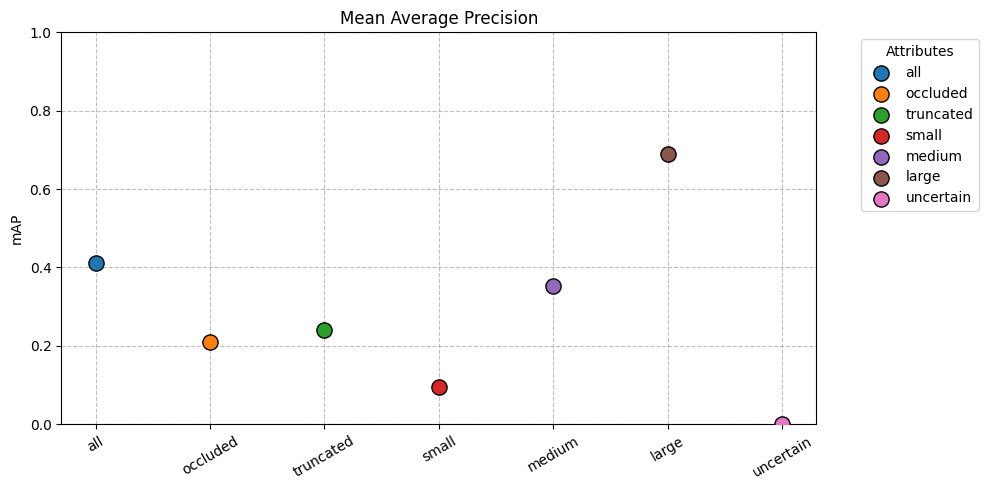

[all] mAP@50 = 0.4114922881126404
[occluded] mAP@50 = 0.21092724800109863
[truncated] mAP@50 = 0.24004940688610077
[small] mAP@50 = 0.095250204205513
[medium] mAP@50 = 0.35268279910087585
[large] mAP@50 = 0.6897674798965454
[uncertain] mAP@50 = 0.0


In [74]:
values = [results["map"][attribute]["map_50"] for attribute in attributes]
plot_attribute_map(attributes, values)

for i, attribute in enumerate(attributes):
    print(f"[{attribute}] mAP@50 = {values[i]}")

### 6.2. Plot across classes by Attributes

### 6.2.1 All Objects

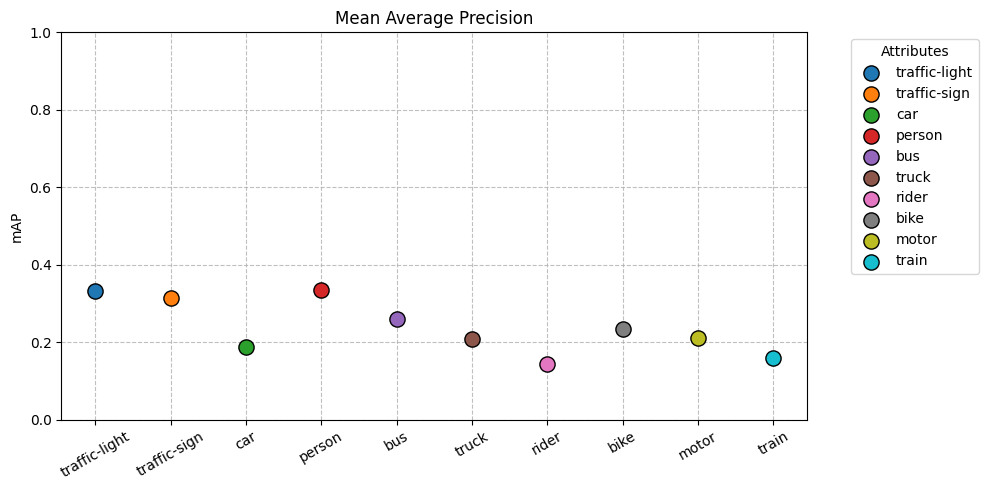

[traffic-light] mAP = 0.33290085196495056
[traffic-sign] mAP = 0.31309518218040466
[car] mAP = 0.18865780532360077
[person] mAP = 0.33362868428230286
[bus] mAP = 0.26038995385169983
[truck] mAP = 0.2084118127822876
[rider] mAP = 0.14468646049499512
[bike] mAP = 0.23274388909339905
[motor] mAP = 0.21038278937339783
[train] mAP = 0.1580198109149933


In [79]:
attribute = "all"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

### 6.2.2 Occluded Objects

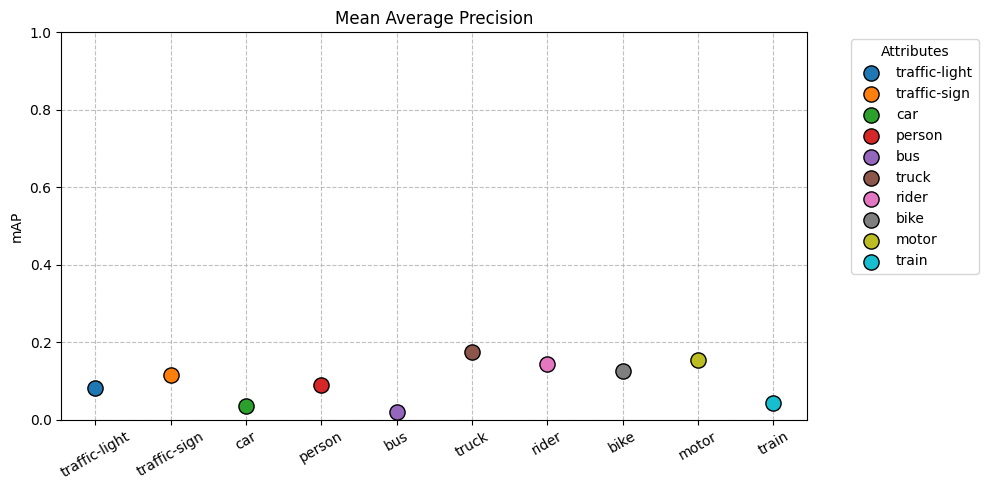

[traffic-light] mAP = 0.08047831058502197
[traffic-sign] mAP = 0.11548382043838501
[car] mAP = 0.03565695509314537
[person] mAP = 0.08958771079778671
[bus] mAP = 0.01929626241326332
[truck] mAP = 0.1739058494567871
[rider] mAP = 0.14402177929878235
[bike] mAP = 0.12439198791980743
[motor] mAP = 0.15501949191093445
[train] mAP = 0.04213421419262886


In [80]:
attribute = "occluded"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

### 6.2.3 Truncated Objects

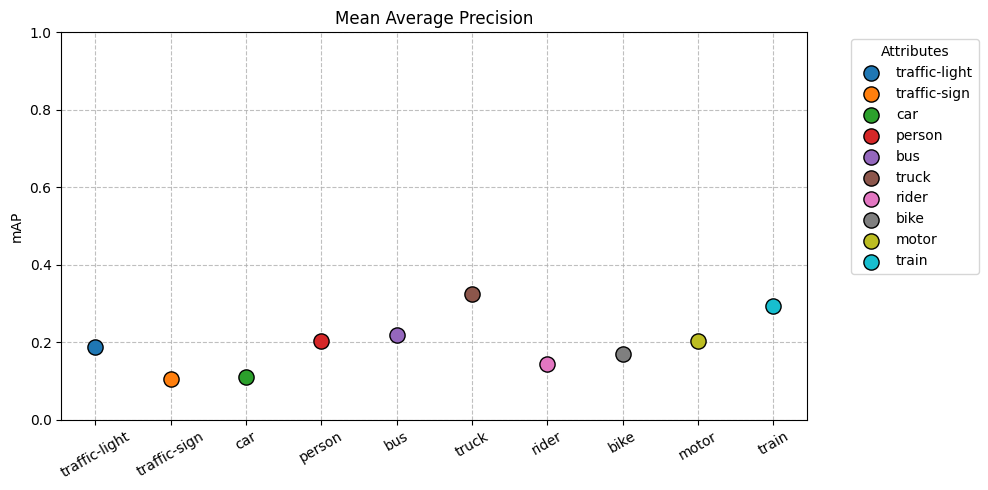

[traffic-light] mAP = 0.1886705458164215
[traffic-sign] mAP = 0.10539356619119644
[car] mAP = 0.11032990366220474
[person] mAP = 0.2018357515335083
[bus] mAP = 0.2192135751247406
[truck] mAP = 0.32494208216667175
[rider] mAP = 0.14450547099113464
[bike] mAP = 0.16985318064689636
[motor] mAP = 0.20331628620624542
[train] mAP = 0.2923937141895294


In [81]:
attribute = "truncated"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

### 6.2.4 Small-sized Objects (area < 32** 2)

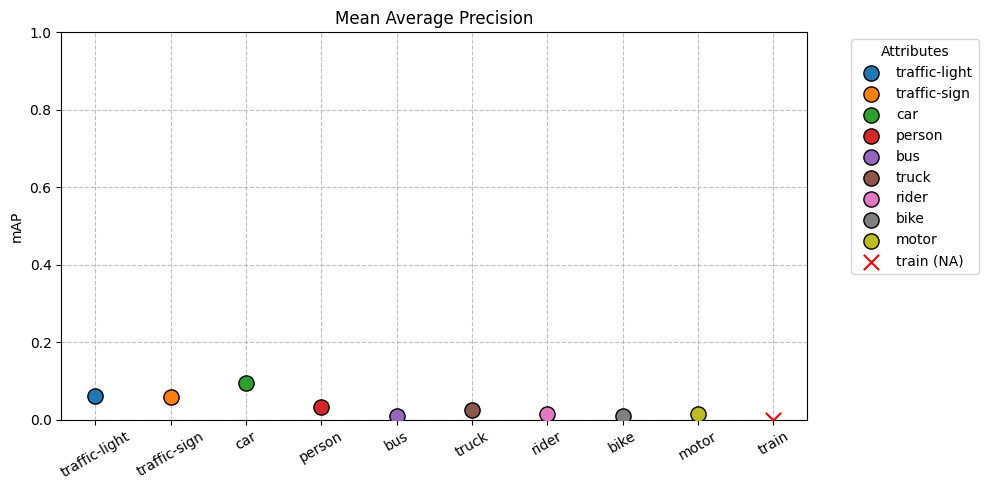

[traffic-light] mAP = 0.05967487767338753
[traffic-sign] mAP = 0.0575973205268383
[car] mAP = 0.09490641951560974
[person] mAP = 0.03325176239013672
[bus] mAP = 0.009111091494560242
[truck] mAP = 0.024000003933906555
[rider] mAP = 0.013333335518836975
[bike] mAP = 0.00982052180916071
[motor] mAP = 0.014295627363026142
[train] mAP = -1


In [82]:
attribute = "small"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

### 6.2.5 Medium-sized Objects (32** 2 < area < 96** 2)

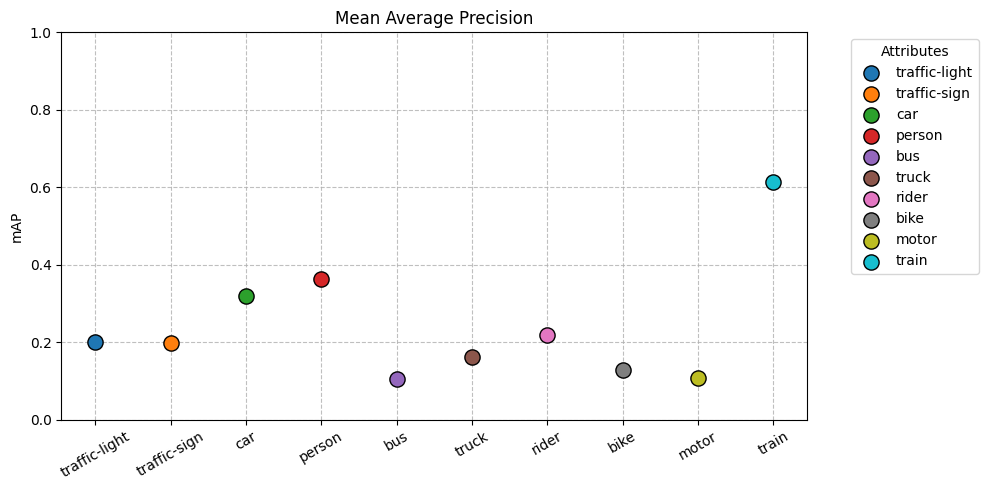

[traffic-light] mAP = 0.19928725063800812
[traffic-sign] mAP = 0.19776591658592224
[car] mAP = 0.3199686110019684
[person] mAP = 0.3630709648132324
[bus] mAP = 0.1045602411031723
[truck] mAP = 0.16222798824310303
[rider] mAP = 0.21775349974632263
[bike] mAP = 0.1270965337753296
[motor] mAP = 0.1083066314458847
[train] mAP = 0.6142585873603821


In [83]:
attribute = "medium"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

### 6.2.6 Large-sized Objects (area > 96** 2)

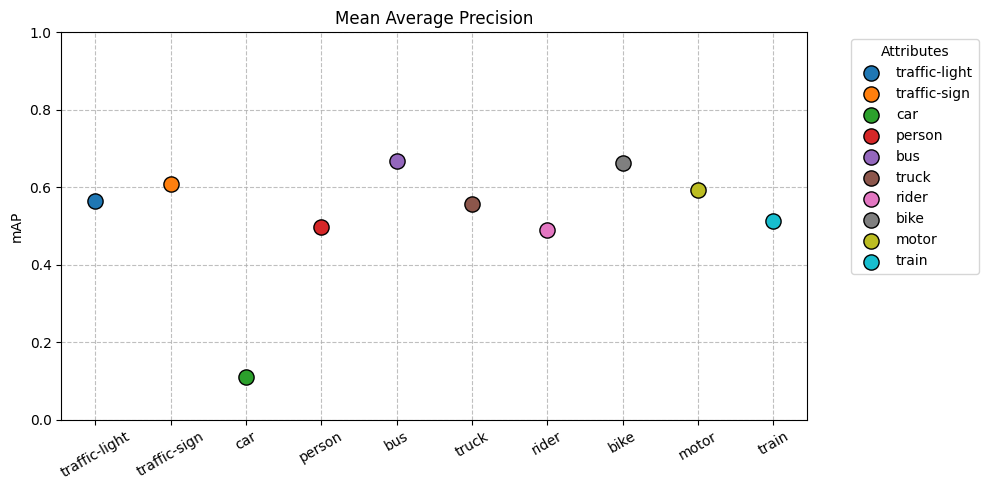

[traffic-light] mAP = 0.5654301047325134
[traffic-sign] mAP = 0.6095605492591858
[car] mAP = 0.11029501259326935
[person] mAP = 0.496706485748291
[bus] mAP = 0.6687938570976257
[truck] mAP = 0.5557950735092163
[rider] mAP = 0.4885510802268982
[bike] mAP = 0.6623985767364502
[motor] mAP = 0.5928786993026733
[train] mAP = 0.512161374092102


In [84]:
attribute = "large"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

### 6.2.7 Uncertain Objects

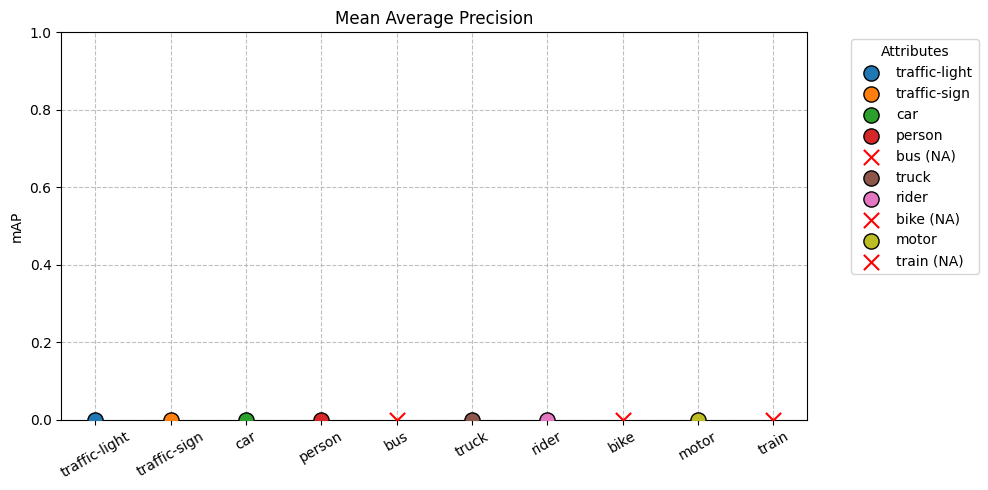

[traffic-light] mAP = 0.0
[traffic-sign] mAP = 0.0
[car] mAP = 0.0
[person] mAP = 0.0
[bus] mAP = -1
[truck] mAP = 0.0
[rider] mAP = 0.0
[bike] mAP = -1
[motor] mAP = 0.0
[train] mAP = -1


In [86]:
attribute = "uncertain"
values = [results["map"][attribute]["map_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_map(classes, values)
for i in range(NUM_CLASSES):
    print(f"[{LABEL_MAP[i]}] mAP = {values[i]}")

## 7. Plots ZRR

In [21]:
def plot_attribute_zrr(labels, values):
    plt.figure(figsize=(10, 5))

    colors = plt.cm.tab10(range(len(labels)))

    for label, val, c in zip(labels, values, colors):
        if val == -1:
            plt.scatter(label, 0, marker="x", color="red", s=120, label=f"{label} (NA)", zorder=3)
        else:
            plt.scatter(label, val, color=c, s=120, edgecolor="black", label=label, zorder=3)

    plt.ylabel("ZRR")
    plt.title("Zero Result Rate")
    plt.xticks(rotation=30)
    plt.ylim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.8, zorder=0)
    plt.grid(axis="y", linestyle="--", alpha=0.8, zorder=0)

    plt.legend(title="Attributes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### 7.1. Plot across Attributes

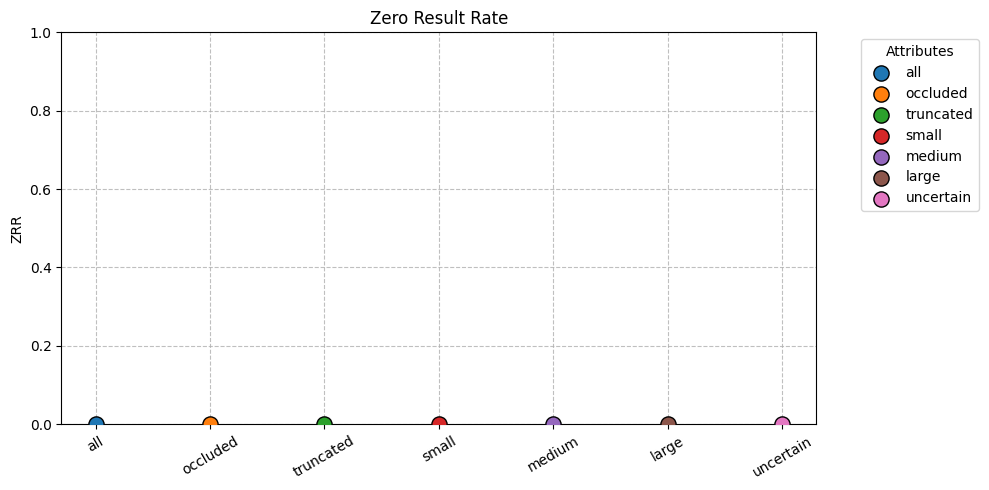

In [42]:
values = [results["zrr"][attribute]["zrr"] for attribute in attributes]
plot_attribute_zrr(attributes, values)

### 7.2. Plot across classes by Attributes

### 7.2.1 All Objects

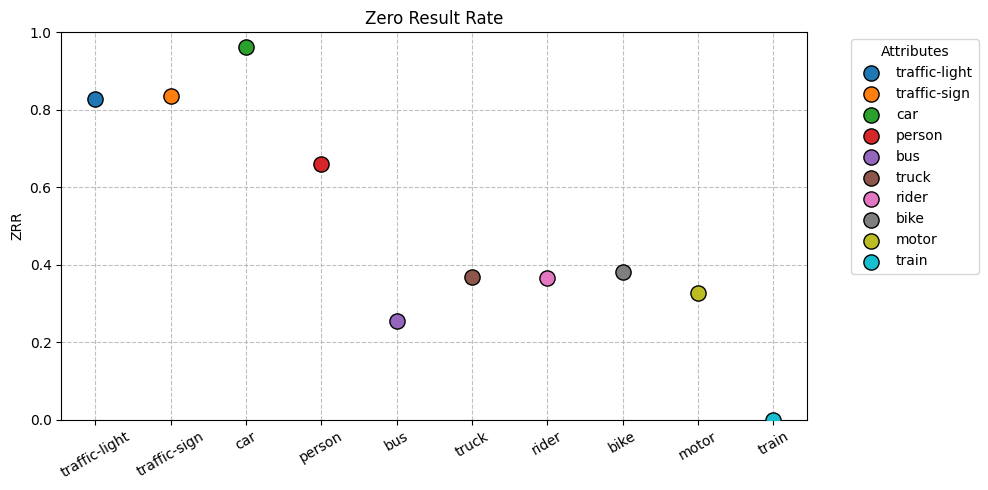

In [43]:
attribute = "all"
values = [results["zrr"][attribute]["zrr_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_zrr(classes, values)

### 7.2.2 Occluded Objects

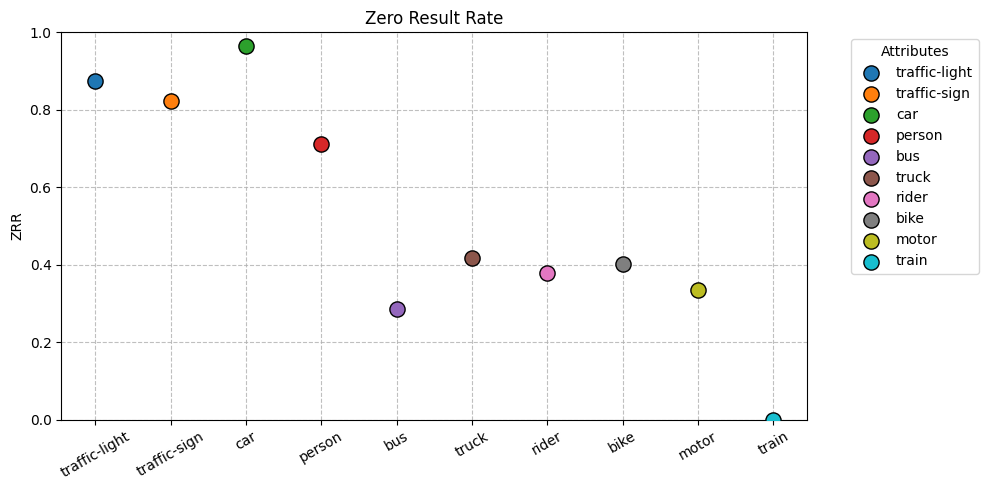

In [44]:
attribute = "occluded"
values = [results["zrr"][attribute]["zrr_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_zrr(classes, values)

### 7.2.3 Truncated Objects

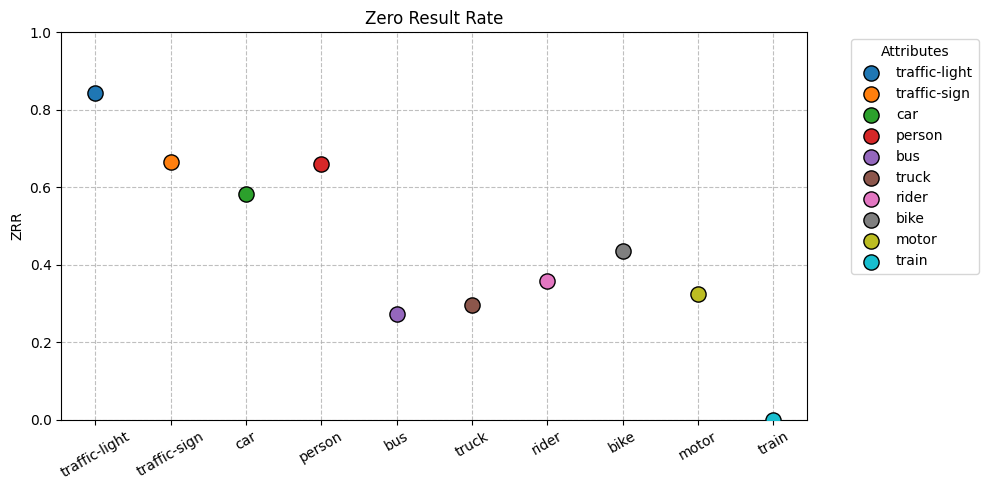

In [45]:
attribute = "truncated"
values = [results["zrr"][attribute]["zrr_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_zrr(classes, values)

### 7.2.4 Small-sized Objects (area < 32** 2)

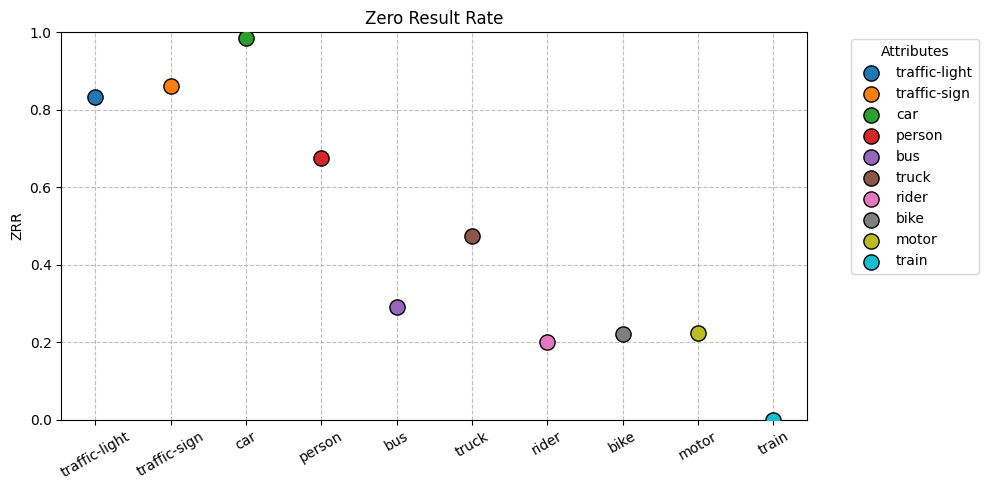

In [46]:
attribute = "small"
values = [results["zrr"][attribute]["zrr_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_zrr(classes, values)

### 7.2.5 Medium-sized Objects (32** 2 < area < 96** 2)

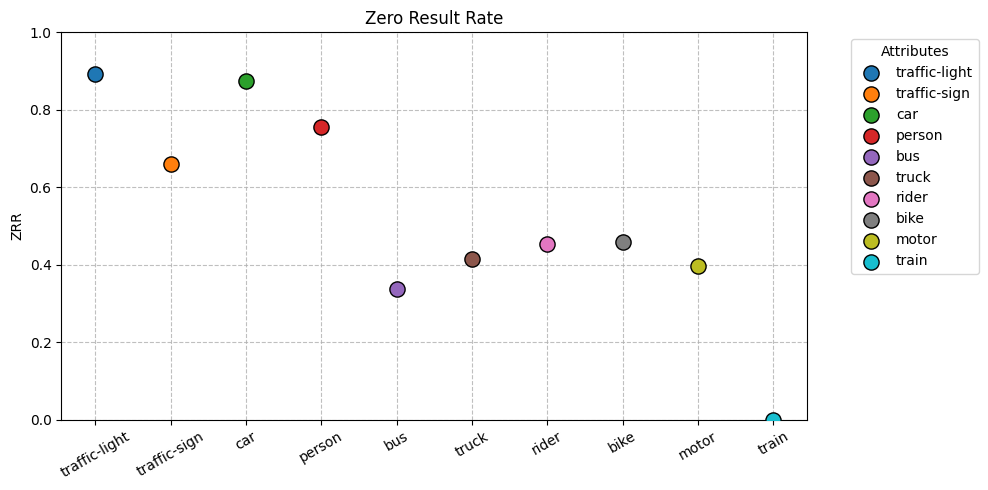

In [47]:
attribute = "medium"
values = [results["zrr"][attribute]["zrr_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_zrr(classes, values)

### 7.2.6 Large-sized Objects (area > 96** 2)

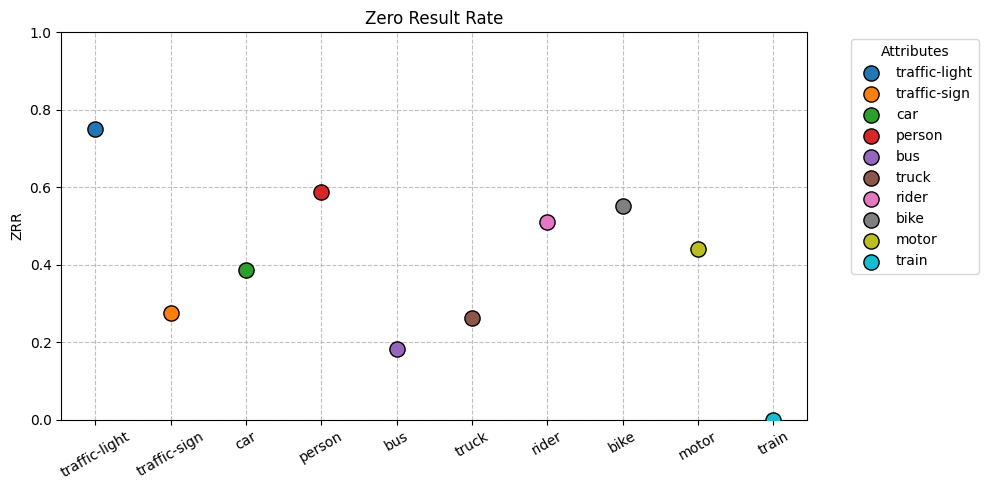

In [48]:
attribute = "large"
values = [results["zrr"][attribute]["zrr_per_class"][i] for i in range(NUM_CLASSES)]
plot_attribute_zrr(classes, values)

## 8. Mapping Metrics to Dataset Analysis

### The higher the `mAP` the better
### The lower the `ZRR` the better

In [69]:
# load computed metrics
eval_metric_path = os.path.join("eval_results", "eval_results.pickle")
with open(eval_metric_path, "rb") as f:
    results = pickle.load(f)

# attribute to metric results mapping
attributes = ["all", "occluded", "truncated", "small", "medium", "large", "uncertain"]
attribute_metrics_dict = {
    attribute: get_result_metrics_df(results, CLASS_MAP, attribute)
    for attribute in attributes
}

# atttribute to image mapping
plot_dir = os.path.join("plots", "val")
attribute2image = get_attribute2image_dict(plot_dir)

## 8.1 All

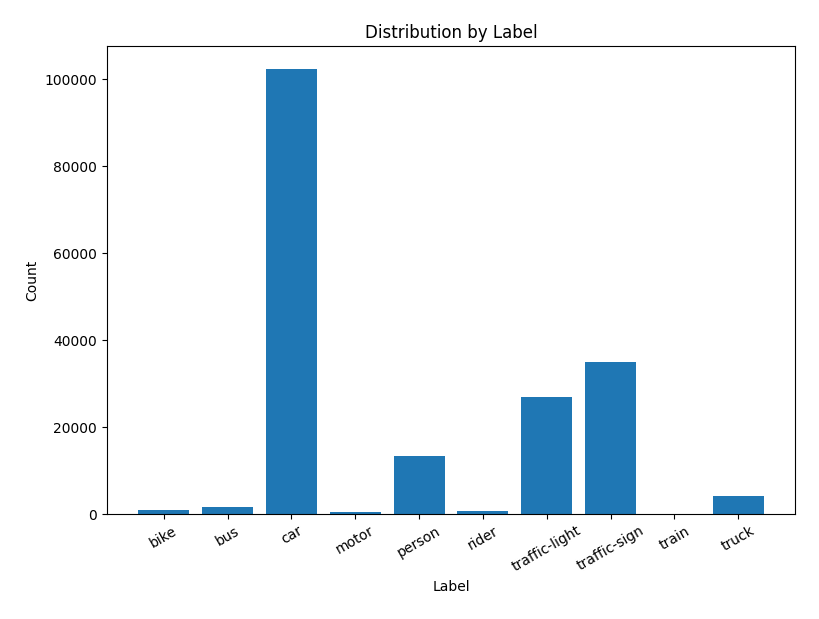

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.332901,0.313095,0.188658,0.333629,0.260390,0.208412,0.144686,0.232744,0.210383,0.15802
1,zrr,0.827879,0.836030,0.962142,0.661180,0.253623,0.367795,0.365049,0.380623,0.326347,0.00000


In [62]:
attribute = "all"
plt.figure(figsize=(8, 6))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]

## 8.2 Occluded

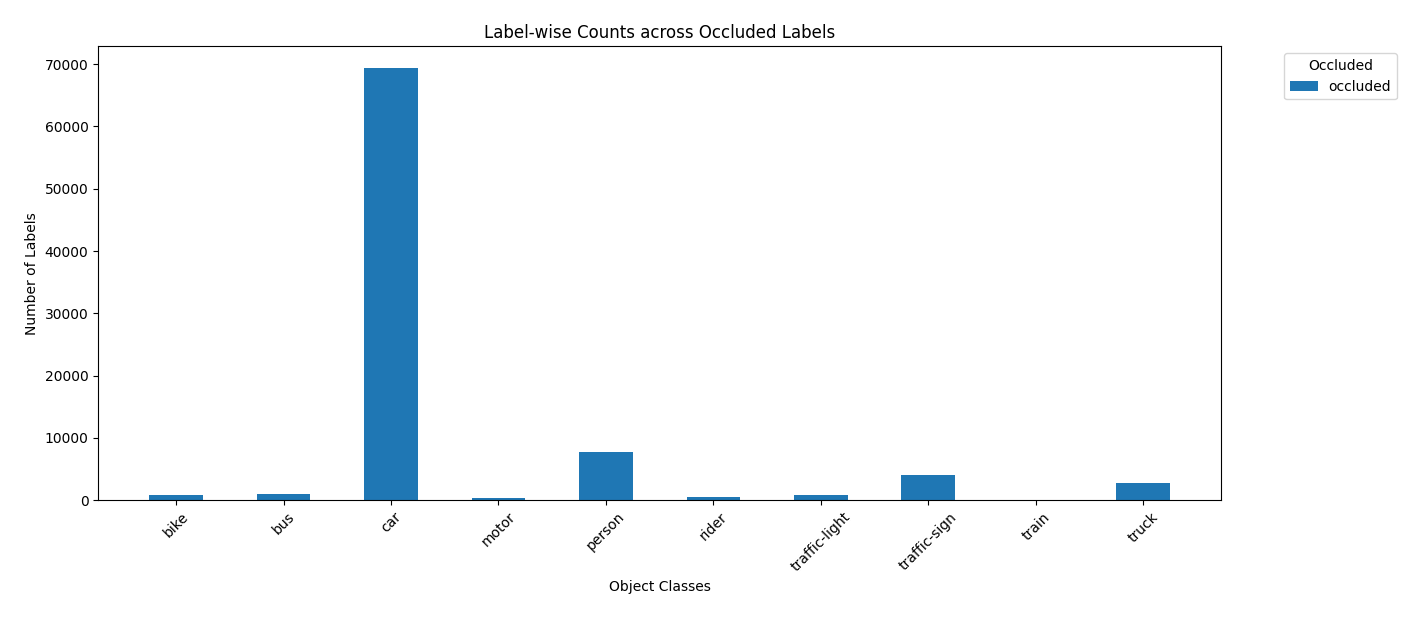

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.080478,0.115484,0.035657,0.089588,0.019296,0.173906,0.144022,0.124392,0.155019,0.042134
1,zrr,0.875614,0.823580,0.965947,0.712297,0.286722,0.416799,0.377682,0.402321,0.334661,0.000000


In [63]:
attribute = "occluded"
plt.figure(figsize=(14, 10))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]

## 8.3 Truncated

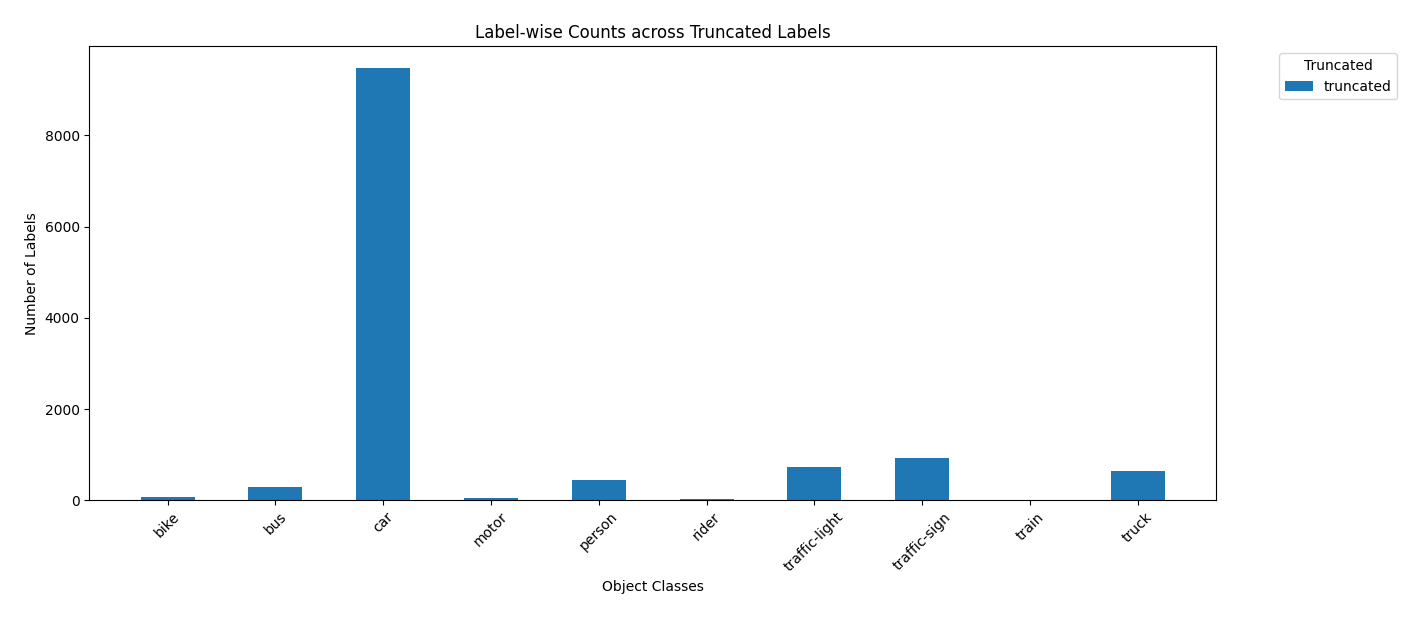

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.188671,0.105394,0.110330,0.201836,0.219214,0.324942,0.144505,0.169853,0.203316,0.292394
1,zrr,0.843687,0.665266,0.583267,0.660428,0.272085,0.296358,0.357143,0.434783,0.325000,0.000000


In [64]:
attribute = "truncated"
plt.figure(figsize=(14, 10))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]

## 8.3 Small (area < 32^2)

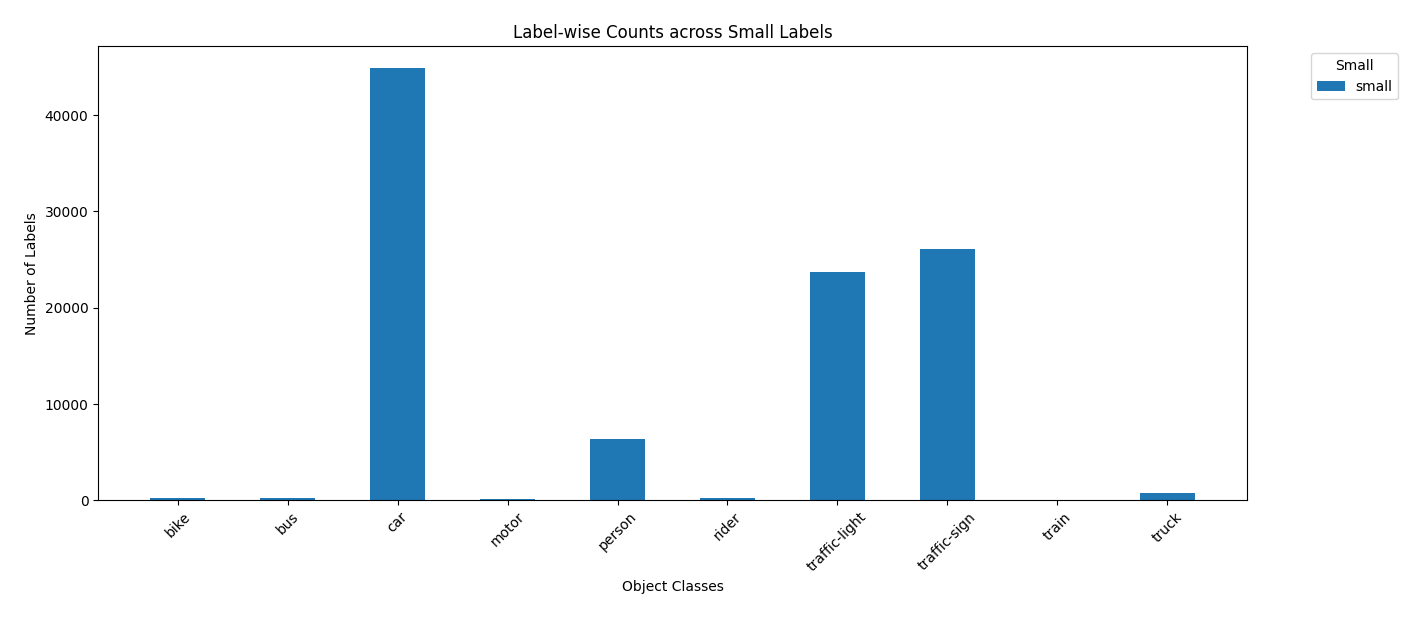

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.059675,0.057597,0.094906,0.033252,0.009111,0.024000,0.013333,0.009821,0.014296,-1.0
1,zrr,0.832932,0.861669,0.984774,0.676153,0.290043,0.474227,0.201005,0.221622,0.224138,0.0


In [65]:
attribute = "small"
plt.figure(figsize=(14, 10))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]

## 8.4 Medium (32^2 < area < 96^2)

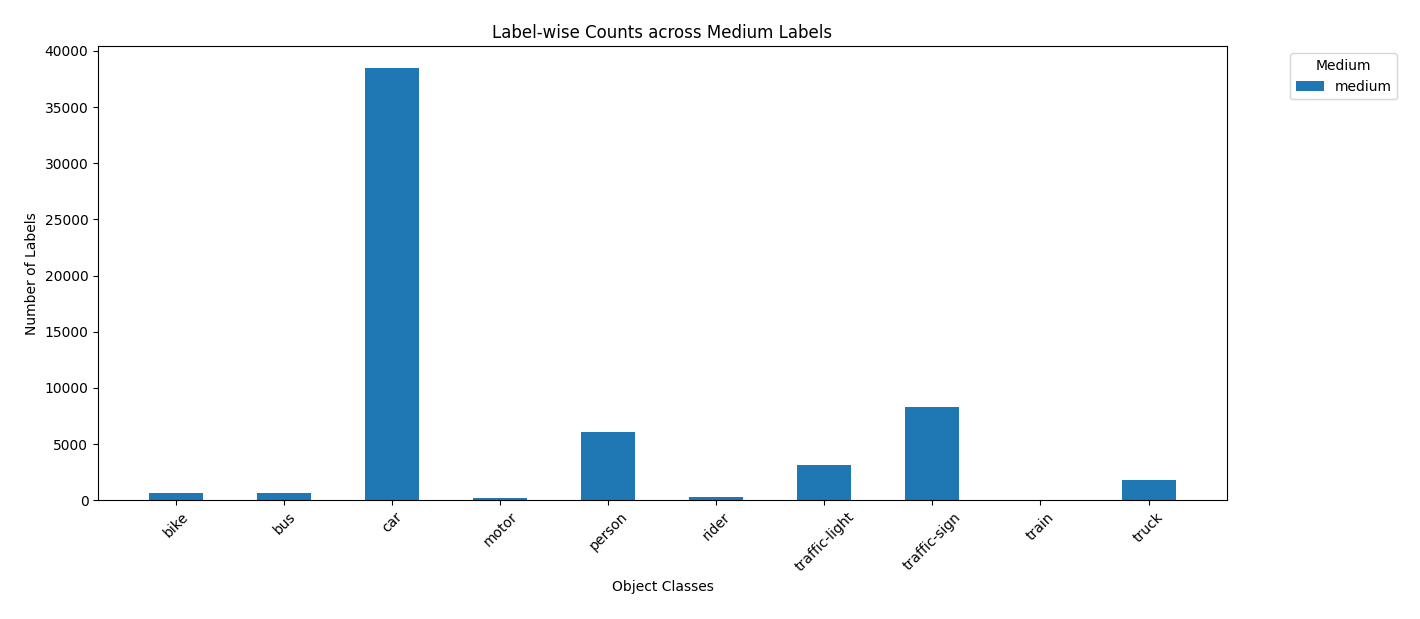

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.199287,0.197766,0.319969,0.363071,0.104560,0.162228,0.217753,0.127097,0.108307,0.614259
1,zrr,0.892269,0.658758,0.873088,0.756805,0.337931,0.415353,0.453532,0.459239,0.396648,0.000000


In [66]:
attribute = "medium"
plt.figure(figsize=(14, 10))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]

## 8.5 Large (area > 96^2)

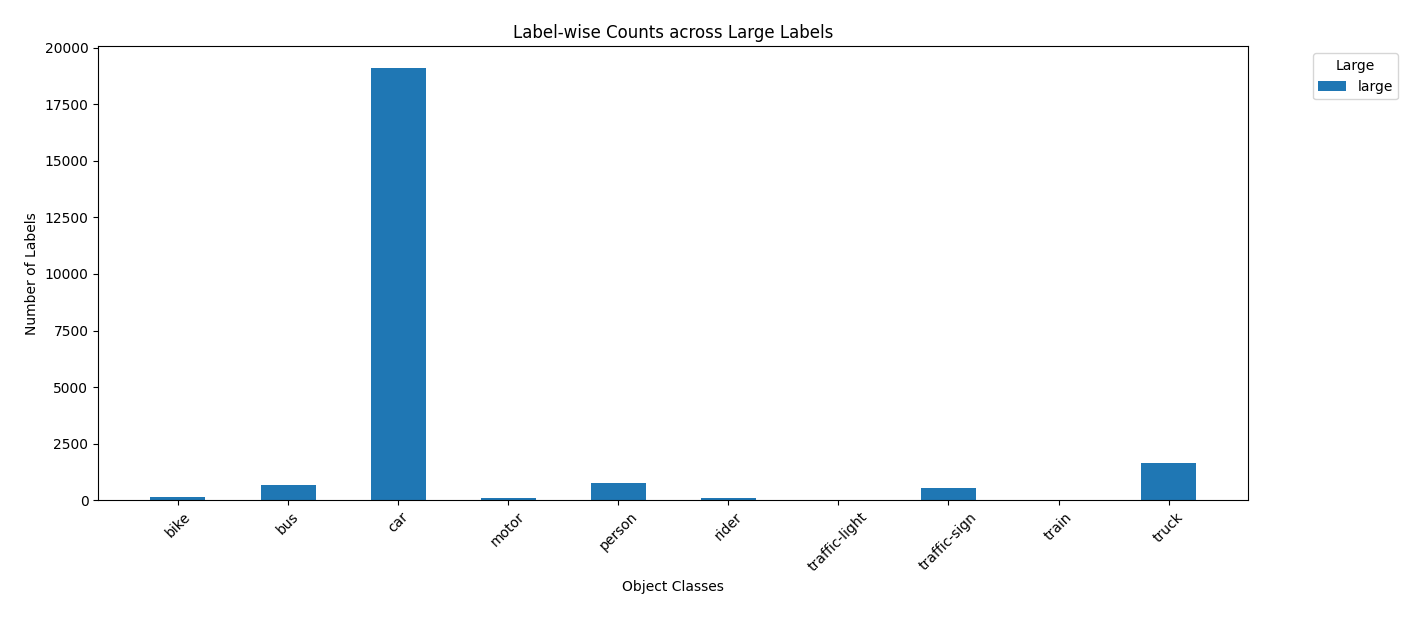

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.56543,0.609561,0.110295,0.496706,0.668794,0.555795,0.488551,0.662399,0.592879,0.512161
1,zrr,0.75000,0.274510,0.386715,0.588000,0.181373,0.262307,0.510417,0.551402,0.440000,0.000000


In [67]:
attribute = "large"
plt.figure(figsize=(14, 10))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]

## 8.6 Uncertain (area < 8^2 and area > 512^2)

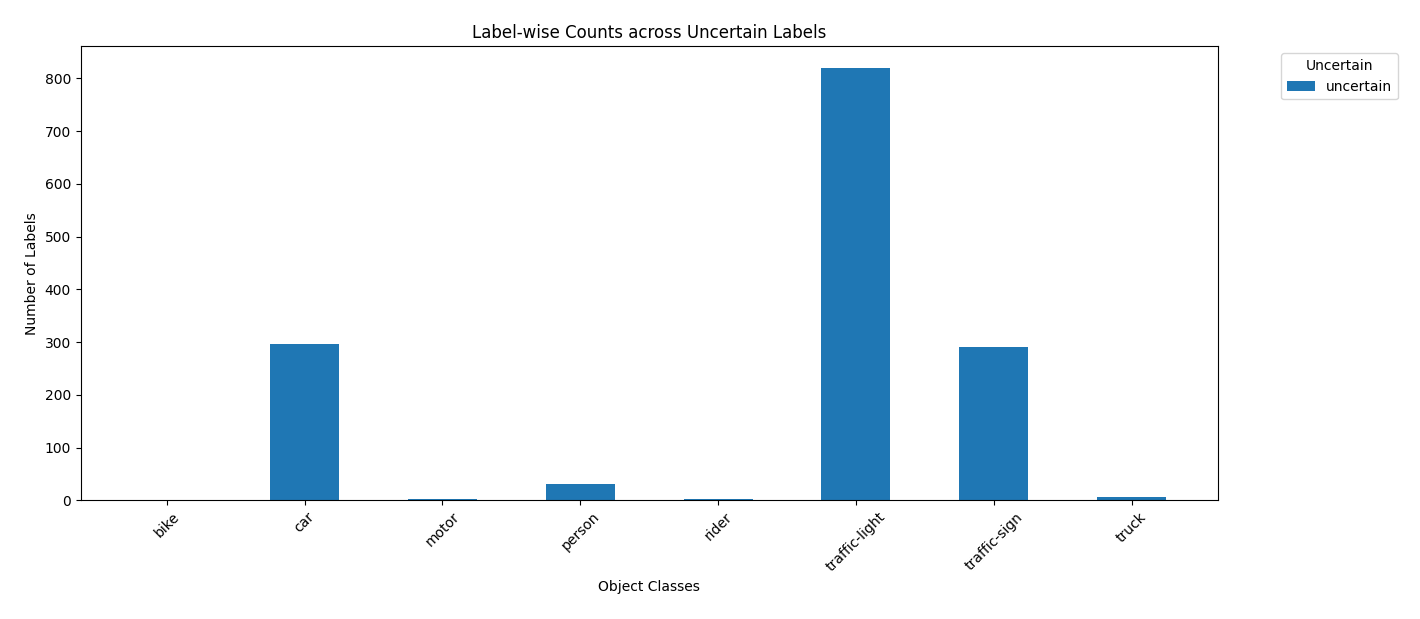

,metric,traffic-light,traffic-sign,car,person,bus,truck,rider,bike,motor,train
0,map,0.000000,0.000000,0.0,0.000000,-1,0.000000,0.0,-1.0,0.0,-1
1,zrr,0.711832,0.873913,1.0,0.740741,-1,0.714286,0.0,1.0,0.0,-1


In [68]:
attribute = "uncertain"
plt.figure(figsize=(14, 10))
plt.imshow(attribute2image[attribute])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
attribute_metrics_dict[attribute]